### Setup Environment:

In [1]:
from src.get_dataset import get_dataset, split_data
from src.data_loader import BRSETDataset, process_labels
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np

# loss function and optimizer
from src.FocalLoss import BinaryFocalLoss, FocalLoss

# train and test functions
from src.train import train
from src.test import test

In [2]:
# Constants:
DATASET = 'C:\\Users\\preet\\Documents\\mBRSET\\mbrset-a-mobile-brazilian-retinal-dataset-1.0\\'
HOME_DIR = 'C:\\Users\\preet\\Documents\\mBRSET\\mBRSET\\' # change this as appropriate 
DOWNLOAD = False
SHAPE = (224, 224)
IMAGES = os.path.join(DATASET, 'images')
LABEL = 'final_icdr'
TEST_SIZE = 0.3
UNDERSAMPLE = False
HOME_DIR = 'C:\\Users\\preet\\Documents\\mBRSET\\mBRSET\\' # change this as appropriate 
LABELS_PATH = os.path.join(DATASET, 'labels.csv')
IMAGE_COL = 'file'

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN = None # [0.485, 0.456, 0.406]
NORM_STD = None # [0.229, 0.224, 0.225]

BACKBONE = 'resnet50'
MODE = 'fine_tune'
backbone_mode = 'fine_tune'

HIDDEN = [128]
num_classes = 2

BATCH_SIZE = 64
NUM_WORKERS = 8

LOSS = None #'focal_loss'
OPTIMIZER = 'adam'
USE_RELU = False
# Define your hyperparameters
num_epochs = 50
learning_rate = 1e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read csv file:

In [3]:
df = get_dataset(DATASET, download=DOWNLOAD, info=False)
df.head()

loading csv file in C:\Users\preet\Documents\mBRSET\mbrset-a-mobile-brazilian-retinal-dataset-1.0\/labels.csv


,patient,age,sex,dm_time,insulin,insulin_time,oraltreatment_dm,systemic_hypertension,insurance,educational_level,...,nephropathy,neuropathy,diabetic_foot,file,laterality,final_artifacts,final_quality,final_icdr,final_edema,normality
0,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.1.jpg,right,yes,yes,4.0,no,abnormal
1,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.2.jpg,right,yes,yes,4.0,no,abnormal
2,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.3.jpg,left,yes,yes,4.0,no,abnormal
3,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.4.jpg,left,yes,yes,4.0,no,abnormal
4,10,63,0,7.0,0.0,NaN,1.0,1.0,0.0,2.0,...,0.0,0.0,0.0,10.1.jpg,right,yes,yes,0.0,no,abnormal


In [4]:
# Convert into 2 classes:

# Normal = 0; Non-proliferative = 1, 2, 3; Proliferative = 4
# for binary: 0: normal, 1-4: abnormal
# Map values to categories
df[LABEL] = df[LABEL].apply(lambda x: 'Normal' if x == 0 else 'Diabetic Retinopathy')

Train data shape: (3614, 25)
Test data shape: (1550, 25)


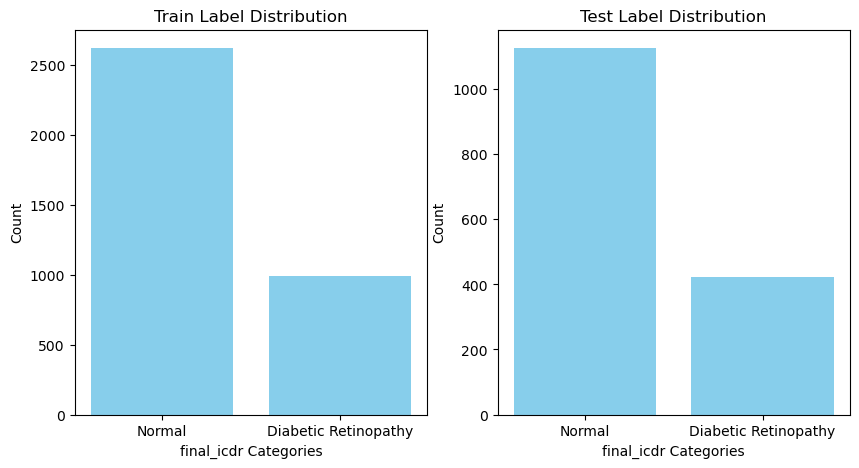

Getting validation set...
Train data shape: (1240, 25)
Test data shape: (310, 25)


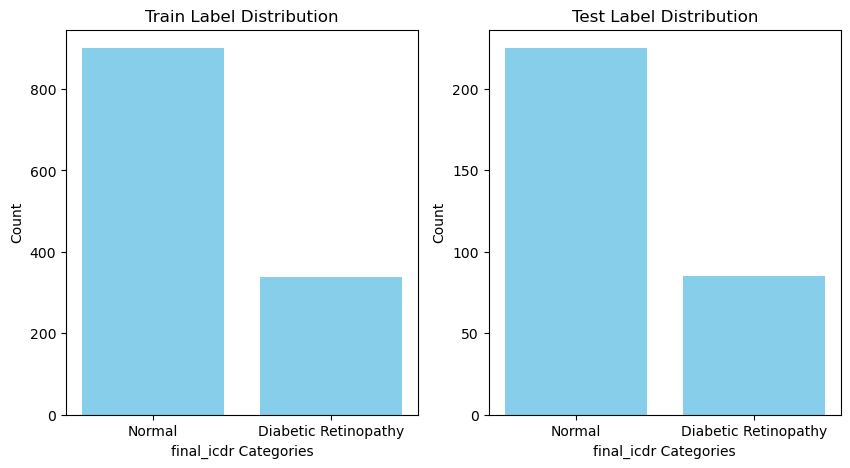

In [5]:
# Split dataset into train, test and validation:
df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=False)
print('Getting validation set...')
df_test, df_val = split_data(df_test, LABEL, 0.20)

### Dataloaders

In [6]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

2810                  {Normal}
1275                  {Normal}
2363                  {Normal}
3185                  {Normal}
5062                  {Normal}
                 ...          
4704    {Diabetic Retinopathy}
2180                  {Normal}
3408    {Diabetic Retinopathy}
4281    {Diabetic Retinopathy}
4724    {Diabetic Retinopathy}
Name: final_icdr, Length: 3614, dtype: object


In [7]:
# Define the target image shape
SHAPE = (224, 224)  # Adjust to your desired image size

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))


In [8]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

DF col dtype object final_icdr
DF col dtype object final_icdr
DF col dtype object final_icdr


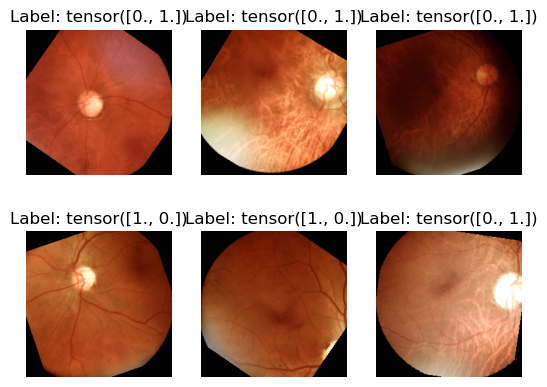

In [9]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels
for batch in train_dataloader:
    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break

### Model

In [10]:
# Create the model
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)
model = FoundationalCVModelWithClassifier(backbone_model, relu = USE_RELU, hidden=HIDDEN, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

### Training:

In [11]:
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    # Assuming train_loader.dataset.labels is a one-hot representation
    class_indices = np.argmax(train_dataloader.dataset.labels, axis=1)

    # Compute class weights using class indices
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [14]:
save_dir= HOME_DIR + 'Experiment1'
model = train(model, train_dataloader, val_dataloader, test_dataloader, criterion, optimizer, num_epochs=num_epochs, save=True, save_dir = save_dir, device="cuda", backbone=f'convnextv2_binary_{LABEL}')

AMP True


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:43<00:00,  1.33it/s]


Epoch 1
Train loss 0.655, F1 0.602, Acc 0.639, BA 0.631
cm[[ 607  383]
 [ 922 1702]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.60s/it]


Epoch 1
Val loss 0.591, F1 0.709, Acc 0.748, BA 0.732
cm[[ 59  26]
 [ 52 173]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.05s/it]


cm[[228 111]
 [215 686]]
              precision    recall  f1-score   support

           0       0.51      0.67      0.58       339
           1       0.86      0.76      0.81       901

    accuracy                           0.74      1240
   macro avg       0.69      0.72      0.70      1240
weighted avg       0.77      0.74      0.75      1240

F1 0.747, Acc 0.737, BA 0.717
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:48<00:00,  1.18it/s]


Epoch 2
Train loss 0.554, F1 0.714, Acc 0.767, BA 0.720
cm[[ 609  381]
 [ 461 2163]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.11s/it]


Epoch 2
Val loss 0.508, F1 0.733, Acc 0.777, BA 0.744
cm[[ 57  28]
 [ 41 184]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.01s/it]


cm[[236 103]
 [187 714]]
              precision    recall  f1-score   support

           0       0.56      0.70      0.62       339
           1       0.87      0.79      0.83       901

    accuracy                           0.77      1240
   macro avg       0.72      0.74      0.73      1240
weighted avg       0.79      0.77      0.77      1240

F1 0.773, Acc 0.766, BA 0.744
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:40<00:00,  1.39it/s]


Epoch 3
Train loss 0.489, F1 0.751, Acc 0.797, BA 0.758
cm[[ 665  325]
 [ 410 2214]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.62s/it]


Epoch 3
Val loss 0.487, F1 0.728, Acc 0.771, BA 0.743
cm[[ 58  27]
 [ 44 181]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.04it/s]


cm[[240  99]
 [187 714]]
              precision    recall  f1-score   support

           0       0.56      0.71      0.63       339
           1       0.88      0.79      0.83       901

    accuracy                           0.77      1240
   macro avg       0.72      0.75      0.73      1240
weighted avg       0.79      0.77      0.78      1240

F1 0.777, Acc 0.769, BA 0.750


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:39<00:00,  1.43it/s]


Epoch 4
Train loss 0.457, F1 0.767, Acc 0.809, BA 0.775
cm[[ 694  296]
 [ 394 2230]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.47s/it]


Epoch 4
Val loss 0.472, F1 0.760, Acc 0.806, BA 0.764
cm[[ 57  28]
 [ 32 193]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.05it/s]


cm[[239 100]
 [139 762]]
              precision    recall  f1-score   support

           0       0.63      0.71      0.67       339
           1       0.88      0.85      0.86       901

    accuracy                           0.81      1240
   macro avg       0.76      0.78      0.77      1240
weighted avg       0.82      0.81      0.81      1240

F1 0.810, Acc 0.807, BA 0.775
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:39<00:00,  1.43it/s]


Epoch 5
Train loss 0.429, F1 0.784, Acc 0.823, BA 0.793
cm[[ 718  272]
 [ 366 2258]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.51s/it]


Epoch 5
Val loss 0.474, F1 0.770, Acc 0.819, BA 0.766
cm[[ 55  30]
 [ 26 199]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.06it/s]


cm[[228 111]
 [117 784]]
              precision    recall  f1-score   support

           0       0.66      0.67      0.67       339
           1       0.88      0.87      0.87       901

    accuracy                           0.82      1240
   macro avg       0.77      0.77      0.77      1240
weighted avg       0.82      0.82      0.82      1240

F1 0.817, Acc 0.816, BA 0.771
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:40<00:00,  1.41it/s]


Epoch 6
Train loss 0.405, F1 0.796, Acc 0.831, BA 0.810
cm[[ 755  235]
 [ 376 2248]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.53s/it]


Epoch 6
Val loss 0.486, F1 0.773, Acc 0.835, BA 0.751
cm[[ 48  37]
 [ 14 211]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.08it/s]


cm[[209 130]
 [ 70 831]]
              precision    recall  f1-score   support

           0       0.75      0.62      0.68       339
           1       0.86      0.92      0.89       901

    accuracy                           0.84      1240
   macro avg       0.81      0.77      0.78      1240
weighted avg       0.83      0.84      0.83      1240

F1 0.833, Acc 0.839, BA 0.769
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:39<00:00,  1.45it/s]


Epoch 7
Train loss 0.388, F1 0.811, Acc 0.844, BA 0.822
cm[[ 765  225]
 [ 338 2286]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.56s/it]


Epoch 7
Val loss 0.483, F1 0.791, Acc 0.842, BA 0.778
cm[[ 54  31]
 [ 18 207]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.06s/it]


cm[[220 119]
 [ 76 825]]
              precision    recall  f1-score   support

           0       0.74      0.65      0.69       339
           1       0.87      0.92      0.89       901

    accuracy                           0.84      1240
   macro avg       0.81      0.78      0.79      1240
weighted avg       0.84      0.84      0.84      1240

F1 0.839, Acc 0.843, BA 0.782
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:40<00:00,  1.40it/s]


Epoch 8
Train loss 0.369, F1 0.820, Acc 0.852, BA 0.833
cm[[ 784  206]
 [ 330 2294]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.49s/it]


Epoch 8
Val loss 0.476, F1 0.784, Acc 0.835, BA 0.773
cm[[ 54  31]
 [ 20 205]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.06it/s]


cm[[227 112]
 [ 99 802]]
              precision    recall  f1-score   support

           0       0.70      0.67      0.68       339
           1       0.88      0.89      0.88       901

    accuracy                           0.83      1240
   macro avg       0.79      0.78      0.78      1240
weighted avg       0.83      0.83      0.83      1240

F1 0.829, Acc 0.830, BA 0.780


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:39<00:00,  1.43it/s]


Epoch 9
Train loss 0.341, F1 0.836, Acc 0.866, BA 0.846
cm[[ 792  198]
 [ 285 2339]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.47s/it]


Epoch 9
Val loss 0.487, F1 0.798, Acc 0.852, BA 0.777
cm[[ 52  33]
 [ 13 212]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.01it/s]


cm[[221 118]
 [ 72 829]]
              precision    recall  f1-score   support

           0       0.75      0.65      0.70       339
           1       0.88      0.92      0.90       901

    accuracy                           0.85      1240
   macro avg       0.81      0.79      0.80      1240
weighted avg       0.84      0.85      0.84      1240

F1 0.843, Acc 0.847, BA 0.786
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:40<00:00,  1.41it/s]


Epoch 10
Train loss 0.337, F1 0.838, Acc 0.866, BA 0.851
cm[[ 811  179]
 [ 305 2319]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.47s/it]


Epoch 10
Val loss 0.479, F1 0.791, Acc 0.839, BA 0.783
cm[[ 56  29]
 [ 21 204]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.02it/s]


cm[[239 100]
 [112 789]]
              precision    recall  f1-score   support

           0       0.68      0.71      0.69       339
           1       0.89      0.88      0.88       901

    accuracy                           0.83      1240
   macro avg       0.78      0.79      0.79      1240
weighted avg       0.83      0.83      0.83      1240

F1 0.830, Acc 0.829, BA 0.790


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:39<00:00,  1.43it/s]


Epoch 11
Train loss 0.319, F1 0.847, Acc 0.874, BA 0.861
cm[[ 826  164]
 [ 293 2331]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.54s/it]


Epoch 11
Val loss 0.483, F1 0.784, Acc 0.826, BA 0.788
cm[[ 60  25]
 [ 29 196]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.07it/s]


cm[[245  94]
 [141 760]]
              precision    recall  f1-score   support

           0       0.63      0.72      0.68       339
           1       0.89      0.84      0.87       901

    accuracy                           0.81      1240
   macro avg       0.76      0.78      0.77      1240
weighted avg       0.82      0.81      0.81      1240

F1 0.814, Acc 0.810, BA 0.783


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:39<00:00,  1.43it/s]


Epoch 12
Train loss 0.289, F1 0.865, Acc 0.889, BA 0.877
cm[[ 842  148]
 [ 254 2370]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.45s/it]


Epoch 12
Val loss 0.496, F1 0.763, Acc 0.810, BA 0.766
cm[[ 57  28]
 [ 31 194]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.04it/s]


cm[[239 100]
 [122 779]]
              precision    recall  f1-score   support

           0       0.66      0.71      0.68       339
           1       0.89      0.86      0.88       901

    accuracy                           0.82      1240
   macro avg       0.77      0.78      0.78      1240
weighted avg       0.82      0.82      0.82      1240

F1 0.823, Acc 0.821, BA 0.785


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:40<00:00,  1.39it/s]


Epoch 13
Train loss 0.277, F1 0.871, Acc 0.894, BA 0.885
cm[[ 857  133]
 [ 250 2374]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.51s/it]


Epoch 13
Val loss 0.528, F1 0.798, Acc 0.848, BA 0.782
cm[[ 54  31]
 [ 16 209]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.05it/s]


cm[[218 121]
 [ 67 834]]
              precision    recall  f1-score   support

           0       0.76      0.64      0.70       339
           1       0.87      0.93      0.90       901

    accuracy                           0.85      1240
   macro avg       0.82      0.78      0.80      1240
weighted avg       0.84      0.85      0.84      1240

F1 0.844, Acc 0.848, BA 0.784
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:39<00:00,  1.44it/s]


Epoch 14
Train loss 0.254, F1 0.887, Acc 0.909, BA 0.894
cm[[ 852  138]
 [ 192 2432]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.47s/it]


Epoch 14
Val loss 0.508, F1 0.792, Acc 0.832, BA 0.797
cm[[ 61  24]
 [ 28 197]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.07it/s]


cm[[242  97]
 [144 757]]
              precision    recall  f1-score   support

           0       0.63      0.71      0.67       339
           1       0.89      0.84      0.86       901

    accuracy                           0.81      1240
   macro avg       0.76      0.78      0.77      1240
weighted avg       0.82      0.81      0.81      1240

F1 0.809, Acc 0.806, BA 0.777


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:40<00:00,  1.42it/s]


Epoch 15
Train loss 0.238, F1 0.889, Acc 0.908, BA 0.904
cm[[ 885  105]
 [ 227 2397]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.43s/it]


Epoch 15
Val loss 0.536, F1 0.789, Acc 0.832, BA 0.789
cm[[ 59  26]
 [ 26 199]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.04it/s]


cm[[241  98]
 [112 789]]
              precision    recall  f1-score   support

           0       0.68      0.71      0.70       339
           1       0.89      0.88      0.88       901

    accuracy                           0.83      1240
   macro avg       0.79      0.79      0.79      1240
weighted avg       0.83      0.83      0.83      1240

F1 0.832, Acc 0.831, BA 0.793


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:39<00:00,  1.43it/s]


Epoch 16
Train loss 0.246, F1 0.890, Acc 0.911, BA 0.900
cm[[ 866  124]
 [ 198 2426]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.54s/it]


Epoch 16
Val loss 0.541, F1 0.776, Acc 0.823, BA 0.775
cm[[ 57  28]
 [ 27 198]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.05it/s]


cm[[234 105]
 [100 801]]
              precision    recall  f1-score   support

           0       0.70      0.69      0.70       339
           1       0.88      0.89      0.89       901

    accuracy                           0.83      1240
   macro avg       0.79      0.79      0.79      1240
weighted avg       0.83      0.83      0.83      1240

F1 0.834, Acc 0.835, BA 0.790


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:39<00:00,  1.44it/s]


Epoch 17
Train loss 0.229, F1 0.897, Acc 0.916, BA 0.905
cm[[ 872  118]
 [ 185 2439]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.47s/it]


Epoch 17
Val loss 0.520, F1 0.767, Acc 0.810, BA 0.774
cm[[ 59  26]
 [ 33 192]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.04it/s]


cm[[247  92]
 [151 750]]
              precision    recall  f1-score   support

           0       0.62      0.73      0.67       339
           1       0.89      0.83      0.86       901

    accuracy                           0.80      1240
   macro avg       0.76      0.78      0.77      1240
weighted avg       0.82      0.80      0.81      1240

F1 0.809, Acc 0.804, BA 0.781


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:39<00:00,  1.45it/s]


Epoch 18
Train loss 0.211, F1 0.904, Acc 0.921, BA 0.918
cm[[ 904   86]
 [ 200 2424]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.47s/it]


Epoch 18
Val loss 0.578, F1 0.783, Acc 0.829, BA 0.780
cm[[ 57  28]
 [ 25 200]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.06it/s]


cm[[242  97]
 [115 786]]
              precision    recall  f1-score   support

           0       0.68      0.71      0.70       339
           1       0.89      0.87      0.88       901

    accuracy                           0.83      1240
   macro avg       0.78      0.79      0.79      1240
weighted avg       0.83      0.83      0.83      1240

F1 0.830, Acc 0.829, BA 0.793


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:39<00:00,  1.44it/s]


Epoch 19
Train loss 0.184, F1 0.914, Acc 0.930, BA 0.925
cm[[ 903   87]
 [ 165 2459]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.59s/it]


Epoch 19
Val loss 0.608, F1 0.798, Acc 0.845, BA 0.787
cm[[ 56  29]
 [ 19 206]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.08s/it]


cm[[238 101]
 [ 98 803]]
              precision    recall  f1-score   support

           0       0.71      0.70      0.71       339
           1       0.89      0.89      0.89       901

    accuracy                           0.84      1240
   macro avg       0.80      0.80      0.80      1240
weighted avg       0.84      0.84      0.84      1240

F1 0.839, Acc 0.840, BA 0.797


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:39<00:00,  1.45it/s]


Epoch 20
Train loss 0.185, F1 0.913, Acc 0.929, BA 0.923
cm[[ 900   90]
 [ 165 2459]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.45s/it]


Epoch 20
Val loss 0.581, F1 0.800, Acc 0.848, BA 0.786
cm[[ 55  30]
 [ 17 208]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.07it/s]


cm[[235 104]
 [ 94 807]]
              precision    recall  f1-score   support

           0       0.71      0.69      0.70       339
           1       0.89      0.90      0.89       901

    accuracy                           0.84      1240
   macro avg       0.80      0.79      0.80      1240
weighted avg       0.84      0.84      0.84      1240

F1 0.840, Acc 0.840, BA 0.794
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:43<00:00,  1.31it/s]


Epoch 21
Train loss 0.174, F1 0.924, Acc 0.938, BA 0.934
cm[[ 916   74]
 [ 149 2475]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.70s/it]


Epoch 21
Val loss 0.609, F1 0.757, Acc 0.803, BA 0.762
cm[[ 57  28]
 [ 33 192]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.03it/s]


cm[[251  88]
 [137 764]]
              precision    recall  f1-score   support

           0       0.65      0.74      0.69       339
           1       0.90      0.85      0.87       901

    accuracy                           0.82      1240
   macro avg       0.77      0.79      0.78      1240
weighted avg       0.83      0.82      0.82      1240

F1 0.822, Acc 0.819, BA 0.794


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:39<00:00,  1.45it/s]


Epoch 22
Train loss 0.163, F1 0.928, Acc 0.941, BA 0.939
cm[[ 925   65]
 [ 147 2477]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.41s/it]


Epoch 22
Val loss 0.590, F1 0.778, Acc 0.826, BA 0.774
cm[[ 56  29]
 [ 25 200]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.08it/s]


cm[[241  98]
 [119 782]]
              precision    recall  f1-score   support

           0       0.67      0.71      0.69       339
           1       0.89      0.87      0.88       901

    accuracy                           0.82      1240
   macro avg       0.78      0.79      0.78      1240
weighted avg       0.83      0.82      0.83      1240

F1 0.827, Acc 0.825, BA 0.789


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:40<00:00,  1.40it/s]


Epoch 23
Train loss 0.155, F1 0.927, Acc 0.941, BA 0.934
cm[[ 910   80]
 [ 132 2492]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.52s/it]


Epoch 23
Val loss 0.629, F1 0.812, Acc 0.858, BA 0.796
cm[[ 56  29]
 [ 15 210]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.04it/s]


cm[[225 114]
 [ 85 816]]
              precision    recall  f1-score   support

           0       0.73      0.66      0.69       339
           1       0.88      0.91      0.89       901

    accuracy                           0.84      1240
   macro avg       0.80      0.78      0.79      1240
weighted avg       0.84      0.84      0.84      1240

F1 0.837, Acc 0.840, BA 0.785
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:39<00:00,  1.43it/s]


Epoch 24
Train loss 0.133, F1 0.940, Acc 0.951, BA 0.950
cm[[ 940   50]
 [ 128 2496]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.57s/it]


Epoch 24
Val loss 0.650, F1 0.784, Acc 0.832, BA 0.778
cm[[ 56  29]
 [ 23 202]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.03it/s]


cm[[233 106]
 [110 791]]
              precision    recall  f1-score   support

           0       0.68      0.69      0.68       339
           1       0.88      0.88      0.88       901

    accuracy                           0.83      1240
   macro avg       0.78      0.78      0.78      1240
weighted avg       0.83      0.83      0.83      1240

F1 0.826, Acc 0.826, BA 0.783


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:39<00:00,  1.43it/s]


Epoch 25
Train loss 0.127, F1 0.942, Acc 0.953, BA 0.952
cm[[ 940   50]
 [ 121 2503]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.46s/it]


Epoch 25
Val loss 0.714, F1 0.808, Acc 0.858, BA 0.789
cm[[ 54  31]
 [ 13 212]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.07it/s]


cm[[214 125]
 [ 61 840]]
              precision    recall  f1-score   support

           0       0.78      0.63      0.70       339
           1       0.87      0.93      0.90       901

    accuracy                           0.85      1240
   macro avg       0.82      0.78      0.80      1240
weighted avg       0.85      0.85      0.84      1240

F1 0.845, Acc 0.850, BA 0.782


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:39<00:00,  1.43it/s]


Epoch 26
Train loss 0.122, F1 0.949, Acc 0.959, BA 0.956
cm[[ 939   51]
 [  97 2527]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.44s/it]


Epoch 26
Val loss 0.678, F1 0.799, Acc 0.842, BA 0.796
cm[[ 59  26]
 [ 23 202]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.08it/s]


cm[[239 100]
 [ 96 805]]
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       339
           1       0.89      0.89      0.89       901

    accuracy                           0.84      1240
   macro avg       0.80      0.80      0.80      1240
weighted avg       0.84      0.84      0.84      1240

F1 0.842, Acc 0.842, BA 0.799


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:39<00:00,  1.46it/s]


Epoch 27
Train loss 0.124, F1 0.945, Acc 0.955, BA 0.955
cm[[ 946   44]
 [ 119 2505]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.44s/it]


Epoch 27
Val loss 0.725, F1 0.806, Acc 0.852, BA 0.795
cm[[ 57  28]
 [ 18 207]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.03it/s]


cm[[225 114]
 [ 75 826]]
              precision    recall  f1-score   support

           0       0.75      0.66      0.70       339
           1       0.88      0.92      0.90       901

    accuracy                           0.85      1240
   macro avg       0.81      0.79      0.80      1240
weighted avg       0.84      0.85      0.84      1240

F1 0.845, Acc 0.848, BA 0.790


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:39<00:00,  1.46it/s]


Epoch 28
Train loss 0.118, F1 0.947, Acc 0.957, BA 0.956
cm[[ 944   46]
 [ 110 2514]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.47s/it]


Epoch 28
Val loss 0.739, F1 0.765, Acc 0.810, BA 0.770
cm[[ 58  27]
 [ 32 193]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.07it/s]


cm[[239 100]
 [116 785]]
              precision    recall  f1-score   support

           0       0.67      0.71      0.69       339
           1       0.89      0.87      0.88       901

    accuracy                           0.83      1240
   macro avg       0.78      0.79      0.78      1240
weighted avg       0.83      0.83      0.83      1240

F1 0.827, Acc 0.826, BA 0.788


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:39<00:00,  1.44it/s]


Epoch 29
Train loss 0.103, F1 0.953, Acc 0.962, BA 0.961
cm[[ 951   39]
 [ 100 2524]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.44s/it]


Epoch 29
Val loss 0.738, F1 0.788, Acc 0.835, BA 0.781
cm[[ 56  29]
 [ 22 203]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.07it/s]


cm[[229 110]
 [ 84 817]]
              precision    recall  f1-score   support

           0       0.73      0.68      0.70       339
           1       0.88      0.91      0.89       901

    accuracy                           0.84      1240
   macro avg       0.81      0.79      0.80      1240
weighted avg       0.84      0.84      0.84      1240

F1 0.842, Acc 0.844, BA 0.791


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:39<00:00,  1.44it/s]


Epoch 30
Train loss 0.097, F1 0.959, Acc 0.967, BA 0.964
cm[[ 947   43]
 [  77 2547]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.48s/it]


Epoch 30
Val loss 0.741, F1 0.778, Acc 0.826, BA 0.774
cm[[ 56  29]
 [ 25 200]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.04it/s]

cm[[234 105]
 [ 93 808]]
              precision    recall  f1-score   support

           0       0.72      0.69      0.70       339
           1       0.88      0.90      0.89       901

    accuracy                           0.84      1240
   macro avg       0.80      0.79      0.80      1240
weighted avg       0.84      0.84      0.84      1240

F1 0.839, Acc 0.840, BA 0.794
Early stopping triggered.


### Test

In [15]:
state_dict = torch.load(HOME_DIR + 'Experiment1\\fine_tuned_resnet50_best.pth')
model.load_state_dict(state_dict, strict=True) 
test(model, test_dataloader, saliency=True, device=device)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.01s/it]

cm[[225 114]
 [ 85 816]]
              precision    recall  f1-score   support

           0       0.73      0.66      0.69       339
           1       0.88      0.91      0.89       901

    accuracy                           0.84      1240
   macro avg       0.80      0.78      0.79      1240
weighted avg       0.84      0.84      0.84      1240

F1 0.837, Acc 0.840, BA 0.785


(array([9.9777216e-01, 9.9744970e-01, 3.6747614e-01, ..., 9.4987488e-01,
        9.6178830e-01, 3.5219881e-04], dtype=float32),
 array([[0., 1.],
        [0., 1.],
        [0., 1.],
        ...,
        [0., 1.],
        [0., 1.],
        [1., 0.]], dtype=float32))